In [347]:
name = 'Tuan Dat Huynh'
student_id = '43855326'
repo = 'https://bitbucket.org/johnny_huynh/comp257_finalproject'

### COMP257 - Final Project  - Melbourne Housing Market: A Visualization Report with Price Prediction Models 

##### Problem Statement

Melbourne House Market has been active and dynamic for a long time and since then has become one of the most potential market for real-estate investors in Australia. However, to be able to make effective investing decisions, it is important to determine which factors having relationship with the change in houses’ prices and construct a relatively accurate predictive model for the changes of houses’ prices in the future. In this project, several graphical analysis will be conducted to reflect the houses’ prices among several houses’ characteristics in recent years, altogether with the construction of predictive models using regression techniques for predicting prices trends in the upcoming years. 

##### Main Dataset
From Kaggle - Melbourne Housing Market:
https://www.kaggle.com/anthonypino/melbourne-housing-market <br>
Other sources are provided below in Reference section. 

##### Key questions and techniques:

Which factors are most correlated to the change of house prices? - Scatter plots, correlation heatmap to explore. <br>
Have house prices in Melbourne changed since the beginning of 2016? - Time series plot. <br>
Which model would be best for price prediction? - Linear Regression to build model and Test-Train-Spliting to test accuracy. <br>
Top and bottom ten suburbs in terms of house's prices - Bar graphs. <br>
How many clusters would be sensible for this dataset and their characteristics? - Hierarchical Clustering and K-means Clustering. <br>
How to combine predictive model and clustering to estimate if a house's price is at its true value?

###### Note: 
This is not an original version of the final report and is not fully aligned with the presentation conducted before. Since some interesting features were introduced by classmates on Thursday presentation's session, I decided to make some amendments to the first version. Changes include: <br>
Introducing distance to closest train station, distance to closest school and distance to closest hospital. <br>
Introducing Hierarchical Clustering as an initial step for K-means clustering. <br>
Re-investigating the appropriate number of clusters.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error as mse
from sklearn import model_selection as ms
import statsmodels.api as sm
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage
import pylab 
from geopy.distance import vincenty


from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



In [65]:
# Read the csv file into a dataframe and check for all column names
house = pd.read_csv('Melbourne_House.csv')
house = house.rename(columns = {'Distance': 'Distance_CBD', 'Lattitude':'X', 'Longtitude':'Y'})
house.columns


Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance_CBD', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'X', 'Y',
       'Regionname', 'Propertycount'],
      dtype='object')

In [348]:
# Quick overview of the dataset
house.describe()

,Rooms,Price,Distance_CBD,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,X,Y,Propertycount
count,23547.00,18396.00,23546.00,23546.00,19066.00,19063.00,18921.00,17410.00,10018.00,11540.00,19243.00,19243.00,23546.00
mean,2.98,1056697.46,10.31,3109.78,2.95,1.57,1.63,551.78,154.53,1964.64,-37.81,145.00,7517.48
std,0.97,641921.67,6.02,94.52,1.00,0.71,0.97,3544.29,462.54,37.60,0.08,0.11,4415.00
min,1.00,85000.00,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,1196.00,-38.18,144.43,129.00
25%,2.00,633000.00,6.20,3047.00,2.00,1.00,1.00,181.00,95.00,1940.00,-37.86,144.94,4385.00
50%,3.00,880000.00,9.50,3101.00,3.00,1.00,2.00,448.00,129.00,1970.00,-37.81,145.00,6567.00
75%,4.00,1302000.00,13.00,3150.00,4.00,2.00,2.00,656.00,180.00,2000.00,-37.76,145.06,10331.00
max,12.00,9000000.00,48.10,3978.00,30.00,12.00,26.00,433014.00,44515.00,2106.00,-37.41,145.53,21650.00


The dataset contains nearly 23500 observations. However, since there are many data points with missing values, we will eventually drop some of them to build a cleaner dataset with values for most variables. Later on in this project many data cleaning tasks are performed to ensure that. <br>
###### Overview:
Price: maximum price is upto 9,000,000 AUD while the 75% quantile price is only 1,302,0000 AUD.<br>
Rooms: number of rooms. 12 rooms seems to be an outlier as well.<br>
Bedroom2: 30 bed rooms for a house seems to be an outlier. <br>
Landsize and BuildingArea: needs to remove outliers since maximum values are very high. <br>
X and Y: coordinates which will be used to calculate other variables and create maps. <br>
Other variables: review the reference link to the dataset for more information. <br>
 


In [349]:
# Import other files and take a look at their descriptions
hospital = pd.read_csv('melbourne hospital.csv')
school = pd.read_csv('melbourne school.csv')
train = pd.read_csv('melbourne train.csv')

Although all Victoria's hospitals and schools are available with coordinates in the hospital and school dataset, there is no dataset with coordinates available for train stations. Therefore, a collection of train station names is gathered through City of Melbourne Data Platform. GeoCoder method from geopy package is then used to locate the X, Y coordinates of these stations and finally Vincenty method is used to calculate the distance from a specific house to its closest train station/ hospital/ school.<br>
Note: all data preparation works were done in a separate notebook.

In [68]:
# Fix mixed up coordinates 
hospital = hospital.rename(columns = {'X': 'Y', 'Y': 'Y1'})
hospital = hospital.rename(columns = {'Y1': 'X'})
hospital.describe()


,Y,X,FID,OBJECTID,CampusCode,Postcode
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,144.68,-37.45,114.00,114.00,3875.70,3348.09
std,1.27,0.85,65.67,65.67,2440.88,283.39
min,141.25,-38.75,1.00,1.00,1010.00,2640.00
25%,144.24,-37.92,57.50,57.50,1685.00,3129.00
50%,145.00,-37.80,114.00,114.00,3030.00,3241.00
75%,145.17,-37.04,170.50,170.50,6495.00,3550.00
max,148.47,-34.18,227.00,227.00,8890.00,3995.00


In [70]:
# Fix mixed up coordinates
school = school.rename(columns = {'X': 'Y', 'Y': 'Y1'})
school = school.rename(columns = {'Y1': 'X'})
school.describe()

,Entity_Type,School_No,Address_Postcode,Postal_Postcode,LGA_ID,Y,X
count,2248.00,2248.00,2248.00,2248.00,2248.00,2248.00,2248.00
mean,1.32,3467.41,3371.23,3372.28,387.64,144.91,-37.59
std,0.46,2508.80,304.37,318.82,216.29,1.08,0.73
min,1.00,1.00,3000.00,3000.00,11.00,141.08,-38.75
25%,1.00,1530.75,3123.00,3122.75,211.00,144.66,-37.97
50%,1.00,2439.50,3226.00,3225.50,367.00,145.04,-37.80
75%,2.00,5172.25,3638.00,3637.25,562.00,145.26,-37.58
max,2.00,8916.00,3996.00,8008.00,939.00,149.75,-34.17


In [71]:
train = train.rename(columns = {'latitude': 'X', 'longitude':'Y'})
clean_set = house.dropna(subset=['X', 'Y', 'Price'])
clean_set.index = range(len(clean_set))
train.describe()

,Unnamed: 0,X,Y
count,253.00,253.00,253.00
mean,126.00,-37.84,145.02
std,73.18,0.18,0.25
min,0.00,-38.35,144.23
25%,63.00,-37.91,144.92
50%,126.00,-37.83,145.02
75%,189.00,-37.76,145.13
max,252.00,-37.19,145.93


All data points with missing values for either Price (since it is a dependent variable) or X, Y (coordinates are required to calculate distance) will be dropped.

In [72]:
# Function to caculate distance between a house and closest train station/ hospital/ school
def min_distance(service):
    closest_distance = []
    for obs in range(len(clean_set)):
        distance_list = []
        first_point = (clean_set.X[obs], clean_set.Y[obs])
        for i in range(len(service)):
            second_point = (service.X[i], service.Y[i])
            distance = vincenty(first_point, second_point).meters
            distance_list.append(distance)
        min_value = np.min(distance_list)
        closest_distance.append(min_value)
    return(closest_distance)
    
    

In [52]:
#  Calculate distance between a specific house and closest train staion/ hospital/ school
service_name = ['train', 'hospital', 'school']
for i, item in enumerate([train, hospital, school]):
    clean_set['Distance_'+service_name[i]] = min_distance(item)
    

In [185]:
# Due to the heavy computing calculation of the above cell, clean_set will be exported to another csv. file
# "final melbourne data.csv' for backing up purpose
clean_set.to_csv('final melbourne data.csv')

In [350]:
# Read the new file into a Dataframe
house_data = pd.read_csv('final melbourne data.csv')
house_data.columns

Index(['Unnamed: 0', 'Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method',
       'SellerG', 'Date', 'Distance_CBD', 'Postcode', 'Bedroom2', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'X', 'Y',
       'Regionname', 'Propertycount', 'Distance_train', 'Distance_hospital',
       'Distance_school'],
      dtype='object')

Distance_train, Distance_hospital and Distance_school is then added to the dataset.

In [352]:
# Due to the non-availability of price of br, dev site and o-res, those data points are removed from the dataset. 
# Add 'Age' variable
house_data['Age'] = 2017 - house_data['YearBuilt']
print(house_data.describe())


       Unnamed: 0    Rooms      Price  Distance_CBD  Postcode  Bedroom2  \
count    15064.00 15064.00   15064.00      15064.00  15064.00  14905.00   
mean      7531.50     2.93 1067009.80         10.29   3107.38      2.91   
std       4348.75     0.96  639212.28          6.07     94.25      0.96   
min          0.00     1.00   85000.00          0.00   3000.00      0.00   
25%       3765.75     2.00  640000.00          6.10   3046.00      2.00   
50%       7531.50     3.00  900000.00          9.30   3087.00      3.00   
75%      11297.25     3.00 1320000.00         13.10   3149.25      3.00   
max      15063.00    12.00 9000000.00         48.10   3977.00     20.00   

       Bathroom      Car  Landsize  BuildingArea  YearBuilt        X        Y  \
count  14903.00 14798.00  13581.00       7753.00    8950.00 15064.00 15064.00   
mean       1.54     1.62    558.40        151.25    1965.86   -37.81   145.00   
std        0.69     0.96   3990.52        519.49      37.00     0.08     0.11   


Age is the number of years since the house was builted up until 2017.

### Linear Model Building
We will perform some exploratory analysis before proceed to building the main models.

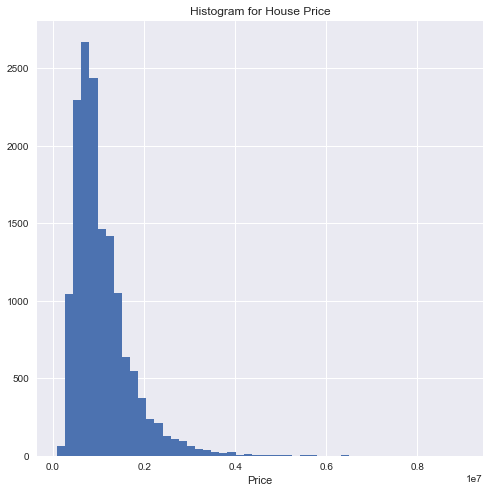

In [252]:
# Histogram of House Price
fig = plt.figure(figsize=(8,8))
plt.hist(house_data['Price'], bins=50)
plt.title('Histogram for House Price')
plt.xlabel('Price')
plt.show()

In [253]:
# Remove data with Price greater than 6,000,000
house_data = house_data[house_data['Price'] < 6000000]

Remove house with prices over 6,000,000 AUD. It is important to exclude outliers from our Linear Model and K-means clustering algorithms, which are very sensitive to outliers and such outliers may distort the real results.

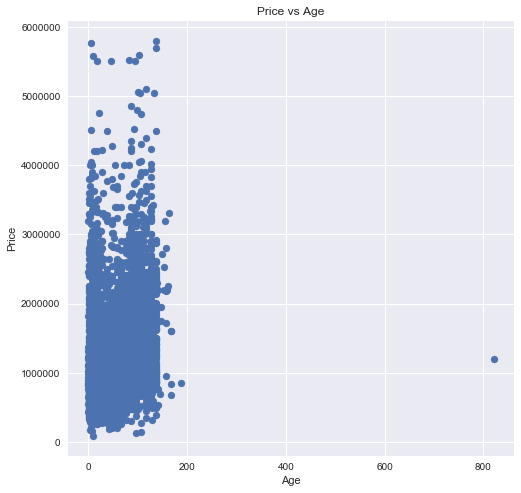

In [254]:
# Scatter plot for Price vs Age
fig = plt.figure(figsize=(8,8))
plt.scatter(house_data['Age'], house_data['Price'])
plt.title('Price vs Age')
plt.xlabel('Age')
plt.ylabel('Price')
plt.show()



Price and Age does not seem to have a strong linear relationship, but let remove the house with more than 800 year-old first.

In [255]:
# Remove data with Age equals 822 years
house_data = house_data[house_data['Age'] < 800]

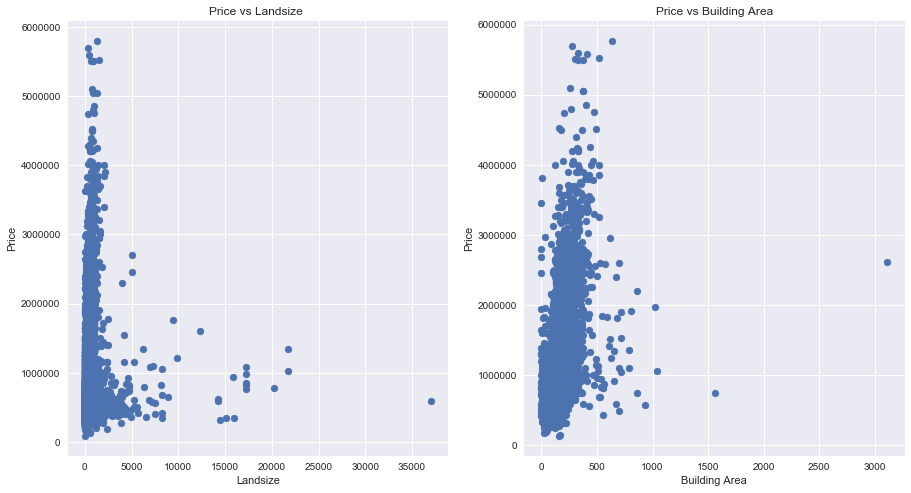

In [256]:
# Scatter plot for Price vs Landsize and BuildingArea
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(house_data.Landsize, house_data.Price)
ax2.scatter(house_data.BuildingArea, house_data.Price)
ax1.set_title('Price vs Landsize ')
ax1.set_xlabel('Landsize')
ax1.set_ylabel('Price')
ax2.set_title('Price vs Building Area')
ax2.set_xlabel('Building Area')
ax2.set_ylabel('Price')
plt.show()

Price and Landsize are not strongly correlated, but Price and Building Area may have a positive linear relationship after the house with more than 3000 squared meters in Area is removed. We will also remove the point with more than 35,000 squared meters in landsize. 

In [353]:
# Remove data with landsize and Building Area equals 0
house_data = house_data[house_data['Landsize'] > 0]
house_data = house_data[house_data['BuildingArea'] > 0]
# Remove data with Building Area greater than 3000
house_data = house_data[house_data.BuildingArea < 3000]
# Remove data with Land Size greater than 35000
house_data = house_data[house_data.Landsize < 35000]



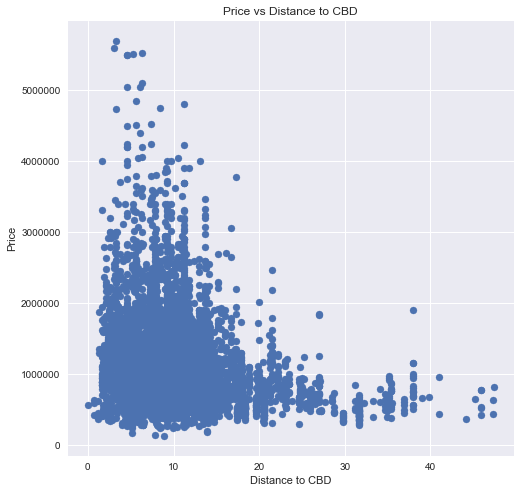

In [258]:
# Scatter plot for Price vs Distance to CBD
fig = plt.figure(figsize=(8,8))
plt.scatter(house_data['Distance_CBD'], house_data['Price'])
plt.title('Price vs Distance to CBD')
plt.xlabel('Distance to CBD')
plt.ylabel('Price')
plt.show()

Distance to CBD is negatively correlated with Price  since the far away a house from the CBD, the cheaper the house is expected.

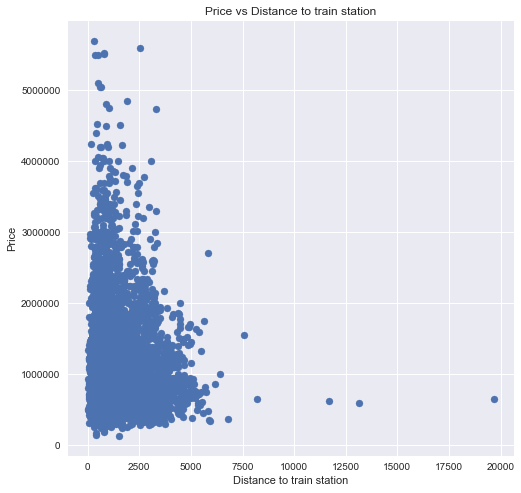

In [259]:
# Scatter plot for Price vs Distance to closest train station
fig = plt.figure(figsize=(8,8))
plt.scatter(house_data['Distance_train'], house_data['Price'])
plt.title('Price vs Distance to train station')
plt.xlabel('Distance to train station')
plt.ylabel('Price')
plt.show()

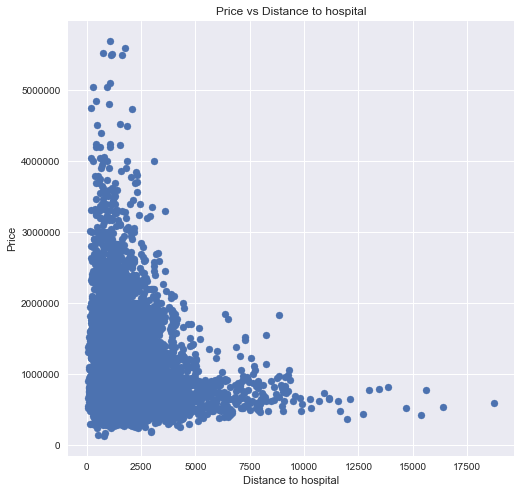

In [260]:
# Scatter plot for Price vs Distance to closest hospital
fig = plt.figure(figsize=(8,8))
plt.scatter(house_data['Distance_hospital'], house_data['Price'])
plt.title('Price vs Distance to hospital')
plt.xlabel('Distance to hospital')
plt.ylabel('Price')
plt.show()

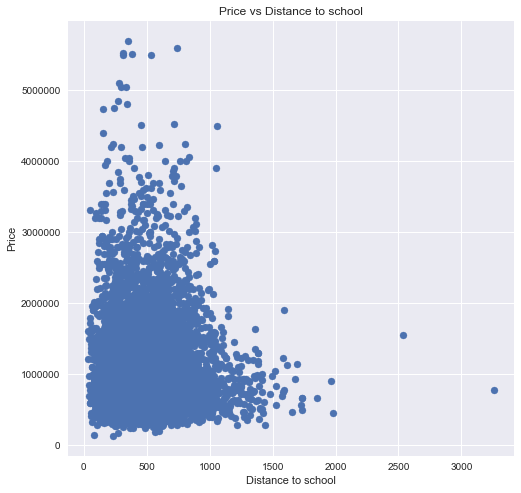

In [261]:
# Scatter plot for Price vs Distance to closest train station
fig = plt.figure(figsize=(8,8))
plt.scatter(house_data['Distance_school'], house_data['Price'])
plt.title('Price vs Distance to school')
plt.xlabel('Distance to school')
plt.ylabel('Price')
plt.show()

Distance to hospital and Distance to train station are slightly negatively correlated with Price, but Distance to school does not seem to have any relation with Price.

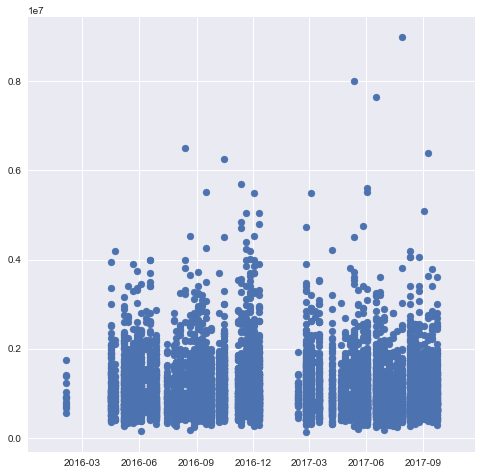

In [354]:
# Scatter plots for historical Price 
date = []
for i in house_data['Date']:
    date_converted = datetime.strptime(i, '%d/%m/%Y')
    date.append(date_converted)
house_data['Date_con'] = date

fig = plt.figure(figsize=(8,8))
plt.scatter(date, house_data['Price'])
plt.show()
    


Price seems to change over years since the beginning of 2016 although the trend was not clear. This is a major difficulity in building house's price prediction, since the prices depend not only on the characteristics of a specific house but also on the current market when the house is sold.

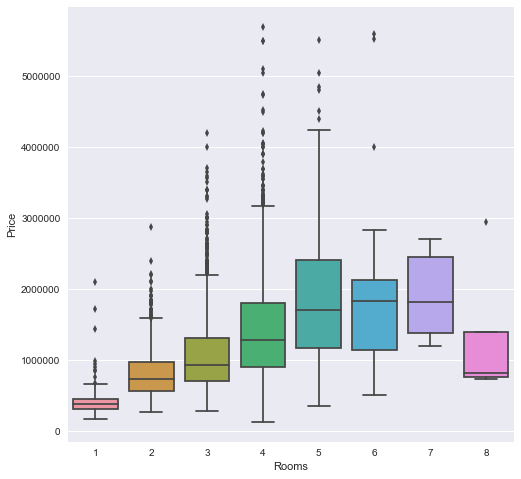

In [308]:
# Boxplots for different number of rooms
fig = plt.figure(figsize=(8,8))
sns.boxplot(house_data['Rooms'], house_data['Price'])
plt.show()

It is clear that the more rooms houses have, the higher in mean price they have. However, because house prices do not only depend on number of rooms, we can see many outliers in the 3,4 and 5 rooms sections, i.e. expensive houses with limited rooms.

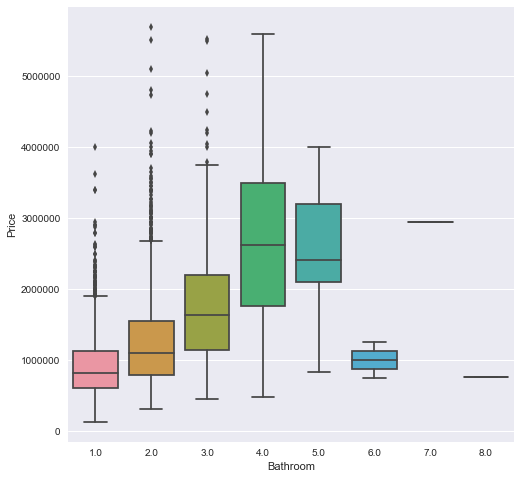

In [309]:
# Boxplots for different number of bathrooms
fig = plt.figure(figsize=(8,8))
sns.boxplot(house_data['Bathroom'], house_data['Price'])
plt.show()

Similarly for number of bathrooms.

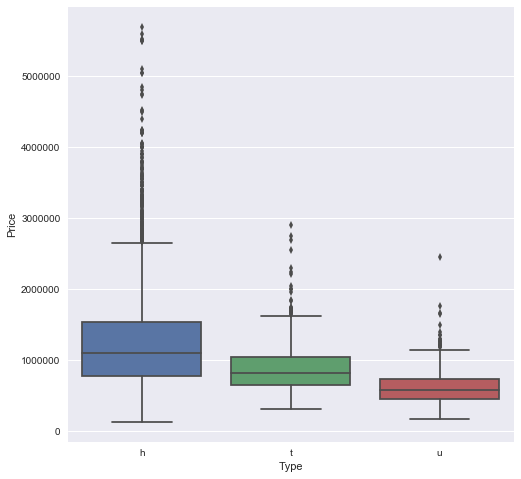

In [264]:
# Boxplots for different number of house types
fig = plt.figure(figsize=(8,8))
sns.boxplot(house_data['Type'], house_data['Price'])
plt.show()


Most outliers gathering in house, cottage, villa, semi and terrace section (h). It is understandable because this type of house is dominated in terms of quantity in our dataset.

In [265]:
# Correlation Matrix 
vars_pairs = ['Price', 'Rooms', 'Distance_CBD', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea','Distance_train',
              'Distance_hospital', 'Distance_school', 'Age']
corr_matrix = house_data[vars_pairs].corr()
corr_matrix

,Price,Rooms,Distance_CBD,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Distance_train,Distance_hospital,Distance_school,Age
Price,1.00,0.46,-0.28,0.44,0.46,0.19,0.01,0.53,-0.10,-0.25,-0.07,0.31
Rooms,0.46,1.00,0.21,0.95,0.60,0.37,0.01,0.62,0.17,0.11,0.09,-0.02
Distance_CBD,-0.28,0.21,1.00,0.22,0.09,0.23,0.04,0.11,0.33,0.47,0.21,-0.36
Bedroom2,0.44,0.95,0.22,1.00,0.60,0.38,0.01,0.60,0.17,0.12,0.09,-0.04
Bathroom,0.46,0.60,0.09,0.60,1.00,0.30,0.04,0.58,0.14,0.05,0.08,-0.21
Car,0.19,0.37,0.23,0.38,0.30,1.00,0.08,0.31,0.12,0.12,0.08,-0.17
Landsize,0.01,0.01,0.04,0.01,0.04,0.08,1.00,0.03,0.05,0.03,0.06,-0.08
BuildingArea,0.53,0.62,0.11,0.60,0.58,0.31,0.03,1.00,0.12,0.05,0.07,-0.09
Distance_train,-0.10,0.17,0.33,0.17,0.14,0.12,0.05,0.12,1.00,0.32,0.22,-0.23
Distance_hospital,-0.25,0.11,0.47,0.12,0.05,0.12,0.03,0.05,0.32,1.00,0.20,-0.22


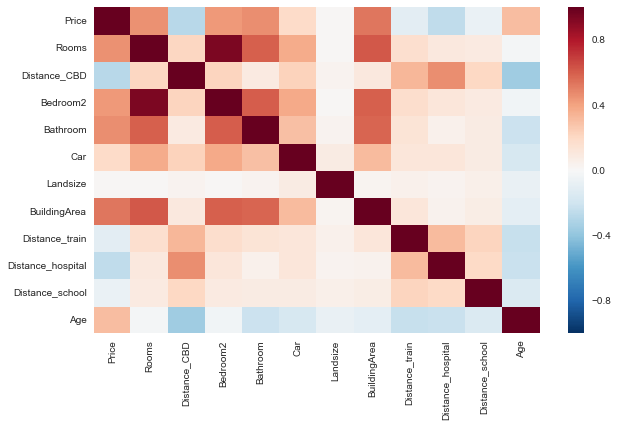

In [266]:
# Seaborn Correlation Heat map
fig_heat = plt.figure(figsize=(10,6))
corr_heatmap = sns.heatmap(corr_matrix)
plt.show(corr_heatmap)

Correlation matrix and correlation heatmap is conducted for variables selection. It is clear that Price is highly correlated with Rooms, Bedroom2, Bathroom, BuildingArea and is moderately correlated with Distance_CBD, Distance_hospital and Age. Price has low correlation with Car, Distance_train and Distance_school. However, we will only include Rooms, Bathroom, BuildingArea and other Distance variables into the model. Since Bedroom is highly correlated with Rooms, it may potentially introduce colinearity in our model. 

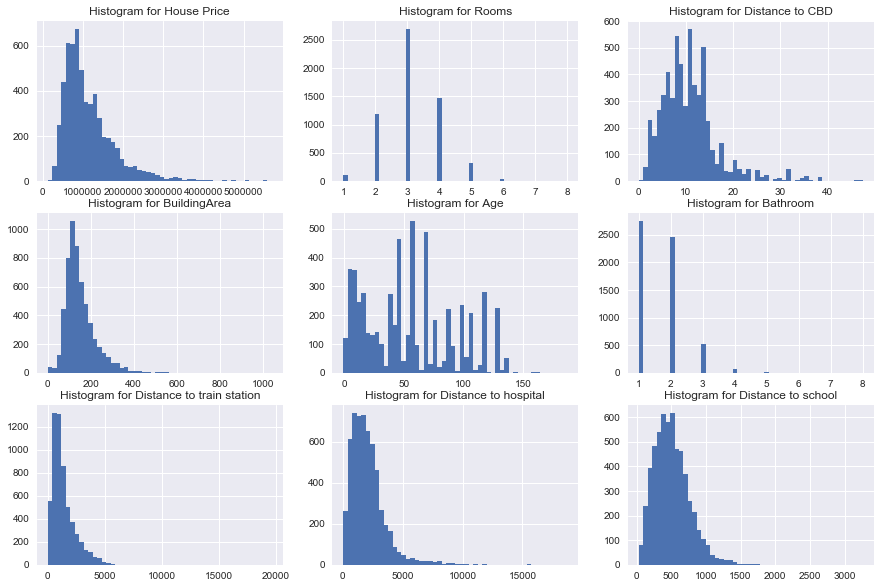

In [267]:
# Histograms to determine distribution
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax1.hist(house_data['Price'], bins=50)
ax1.set_title('Histogram for House Price')
ax2.hist(house_data['Rooms'],bins=50)
ax2.set_title('Histogram for Rooms')
ax3.hist(house_data['Distance_CBD'],bins=50)
ax3.set_title('Histogram for Distance to CBD')
ax4.hist(house_data['BuildingArea'],bins=50)
ax4.set_title('Histogram for BuildingArea')
ax5.hist(house_data['Age'],bins=50)
ax5.set_title('Histogram for Age')
ax6.hist(house_data['Bathroom'],bins=50)
ax6.set_title('Histogram for Bathroom')
ax7.hist(house_data['Distance_train'],bins=50)
ax7.set_title('Histogram for Distance to train station')
ax8.hist(house_data['Distance_hospital'],bins=50)
ax8.set_title('Histogram for Distance to hospital')
ax9.hist(house_data['Distance_school'],bins=50)
ax9.set_title('Histogram for Distance to school')
plt.show()

When Linear Regression technique is used, we should ensure all selected variables are Normally distributed. As indicated above by several histograms, their distributions are almost left-skewed. To deal with that, we will perform Log Transformation for all of them except Rooms and Bathroom.

In [355]:
# Using a subset to add transformation of variables
subset = house_data
transform_vars = ['Price','Distance_CBD', 'BuildingArea', 'Age', 'Distance_train', 'Distance_hospital', 
                  'Distance_school']
# Make sure Log transformation can be performed on every variable
for var in transform_vars:
    subset = subset[subset[var] > 0 ]
# Log transformation    
for var in transform_vars:
    subset['Log'+var] = np.log(subset[var])

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     705.3
Date:                Sun, 12 Nov 2017   Prob (F-statistic):               0.00
Time:                        18:38:49   Log-Likelihood:                -1437.3
No. Observations:                4350   AIC:                             2893.
Df Residuals:                    4341   BIC:                             2950.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   12.5942 

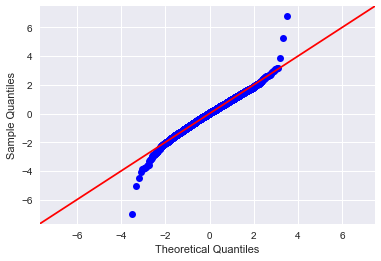

In [269]:
# Split data into train and test sets
subset_train, subset_test = ms.train_test_split(subset, test_size=0.25, random_state=42)
# Fit a linear regression using OLS method on train set
regress_vars = ['LogDistance_CBD', 'LogBuildingArea', 'LogAge', 'Bathroom', 'Rooms', 'LogDistance_train', 'LogDistance_hospital', 
               'LogDistance_school']
x = subset_train[regress_vars]
y = subset_train['LogPrice']
x = sm.add_constant(x)

lm = sm.OLS(y, x).fit()
predicted_values = lm.predict(x)
print(lm.summary())

# Predictions for test set
final_model = LinearRegression(fit_intercept =True)
final_model.fit(subset_train[regress_vars], 
                subset_train[['LogPrice']]) 
test_predictions = final_model.predict(subset_test[regress_vars])
print()
print("RMSE:", np.sqrt(mse(test_predictions, subset_test['LogPrice'])))

# Normal QQ plot diagnosis
residuals = predicted_values - subset_train['LogPrice']
std_residuals = (residuals - residuals.mean())/ residuals.std()
sm.qqplot(std_residuals, line='45')
pylab.show()


The data is then splited into 75% for training and 25% for testing. We apply a Linear Regression using OLS method on the train data set and get the summary table as anove. <br>
Our final model is: <br>
LogPrice = 12.5942 - 0.2676*LogDistance_CBD + 0.2933*LogBuildingArea + 0.1235*LogAge + 0.1741*Bathroom + 0.1375*Rooms - 0.0275 * LogDistance_train - 0.0886 * LogDistance_hospital + 0.0101 * LogDistance_school <br>

All variables are highly significant (except for LogDistance_school) and their coefficients are as expected. The more spacious, more Bathroom and more Room a house has, the more expensive it is in general. The further they are from CBD, train stations and hospitals, the more cheaper they are. Age is a special feature and we do not have any expectation for it in advance, but it turns out to be positively correlated with house' prices. <br>
We also got a R squared of 56.5%, which is acceptable. When apply the model to the test set, we got a RMSE of 0.338, which is quite low and indecated that the predictive model is highly accurate. <br>
Finally, we perform Normality assumption analysis and got a nearly resembled straight line although there are some curves at two ends of the line. However, it shows that we still get a generaly good model.

### Clustering
In this section, we will discover how houses are clustered and the characteristics of each cluster. 

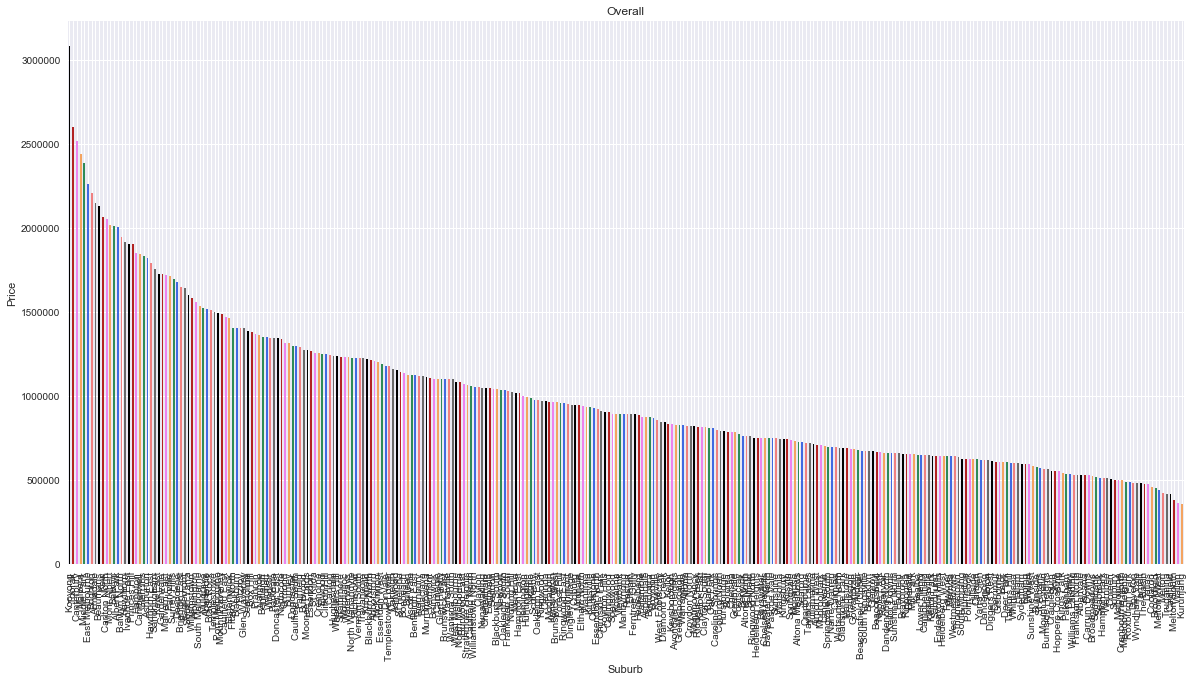

In [356]:
# Mean houses' prices by suburbs
price_by_sub = house_data.groupby(['Suburb'])['Price'].mean()
price_by_sub.sort_values(inplace=True, ascending=False)
# Overall chart of house price
fig = plt.figure(figsize=(20,10))
my_colors = ['black', 'firebrick', 'violet', 'sandybrown', 'seagreen', 'royalblue', 'lightcoral', 'dimgrey']
price_by_sub.plot(kind='bar', color=my_colors)
plt.title('Overall')
plt.ylabel('Price')
plt.show()

An overview of mean houses' prices in all suburbs, ranging from around 400,000 AUD to approximately 3,000,000 AUD. 

In [272]:
# Ten most expensive suburbs
top_ten = price_by_sub[0:10]
top_ten = top_ten.sort_values(ascending=True)
print(top_ten)

Suburb
Mont Albert     2019333.33
Carlton North   2124833.33
Beaumaris       2130400.00
Middle Park     2138312.50
Brighton        2146140.12
Armadale        2149435.48
Canterbury      2277895.83
Toorak          2379173.91
Malvern         2479153.85
Kooyong         3080000.00
Name: Price, dtype: float64


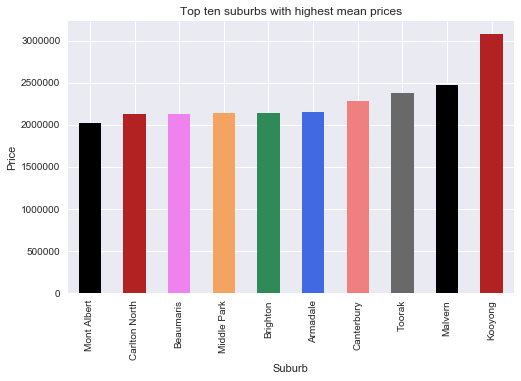

In [213]:
# Top-ten suburbs
fig = plt.figure(figsize=(8,5))
top_ten.plot(kind='bar', color=my_colors)
plt.title('Top ten suburbs with highest mean prices')
plt.ylabel('Price')
plt.show()

Top suburbs are Kooyong, Malvern and Toorak to name a few. Their mean prices are all over 2,000,000 AUD.

In [214]:
# Ten cheapest suburbs
bottom_ten = price_by_sub[len(price_by_sub)-10:len(price_by_sub)]
print(bottom_ten)


Suburb
Dallas         476000.00
Coolaroo       458500.00
Brookfield     456000.00
Melton West    443416.67
Melton         426650.00
Truganina      420500.00
Melton South   382277.78
Wallan         366000.00
Kurunjang      360666.67
Caulfield      340500.00
Name: Price, dtype: float64


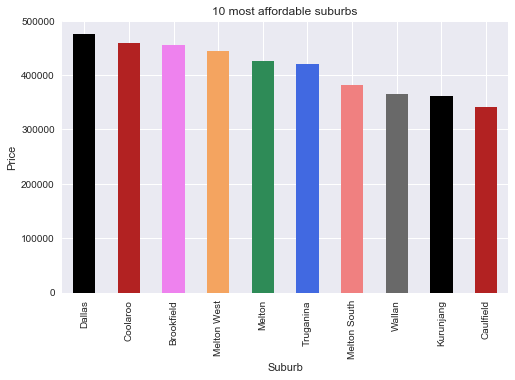

In [215]:
# Cheapest suburb
fig = plt.figure(figsize=(8,5))
bottom_ten.plot(kind='bar', color=my_colors)
plt.title('10 most affordable suburbs')
plt.ylabel('Price')
plt.show()

Top three most affordable suburbs are Caulfield, Kurunjang and Wallan. Note that this is by no mean represented for the whole population. A suburb may be ranked low just because there is not enough data for sold houses in that suburb, or because all public records are only the cheapest houses in that area.

Regionname
Western Victoria              408150.00
Northern Victoria             577538.46
Eastern Victoria              681356.50
South-Eastern Metropolitan    903185.52
Western Metropolitan          911082.14
Northern Metropolitan         932635.68
Eastern Metropolitan         1130059.62
Southern Metropolitan        1597908.62
Name: Price, dtype: float64


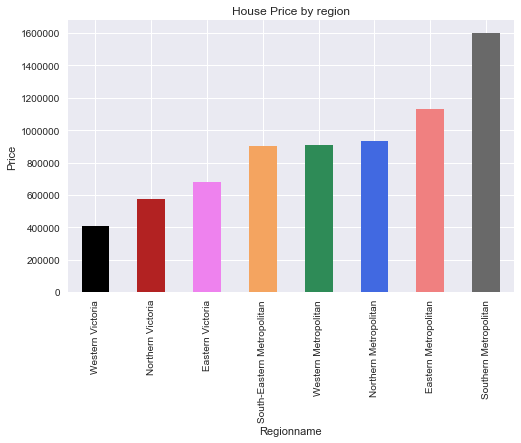

In [216]:
# Mean houses' prices by regions
price_by_region = house_data.groupby(['Regionname'])['Price'].mean()
price_by_region.sort_values(inplace=True, ascending=True)
print(price_by_region)
# Bar graph by regions
fig = plt.figure(figsize=(8,5))
price_by_region.plot(kind='bar', color=my_colors)
plt.title('House Price by region')
plt.ylabel('Price')
plt.show()


In terms of region, the most expensive region is Southern Metropolitan, followed by Eastern Metropolitan and Northern Metropolitan. The cheapest region is Western Victoria. Let's take a look at the map of where are the houses located in these regions.

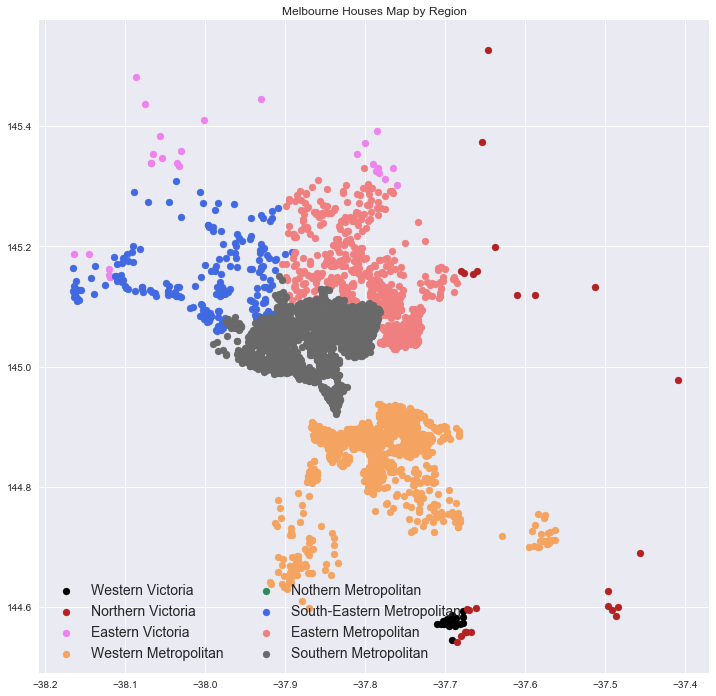

In [321]:
# Melbourne Houses Map by Region
fig = plt.figure(figsize=(12,12))

wv = plt.scatter(house_data[house_data.Regionname=='Western Victoria']['X'], house_data[house_data.Regionname=='Western Victoria']
                 ['Y'], color=my_colors[0])
nv = plt.scatter(house_data[house_data.Regionname=='Northern Victoria']['X'], house_data[house_data.Regionname=='Northern Victoria']
                 ['Y'], color=my_colors[1])
ev = plt.scatter(house_data[house_data.Regionname=='Eastern Victoria']['X'], house_data[house_data.Regionname=='Eastern Victoria']
                 ['Y'], color=my_colors[2])
wm = plt.scatter(house_data[house_data.Regionname=='Western Metropolitan']['X'], house_data[house_data.Regionname=='Western Metropolitan']
                 ['Y'], color=my_colors[3])
nm = plt.scatter(house_data[house_data.Regionname=='Nothern Metropolitan']['X'], house_data[house_data.Regionname=='Nothern Metropolitan']
                 ['Y'], color=my_colors[4])
se = plt.scatter(house_data[house_data.Regionname=='South-Eastern Metropolitan']['X'], house_data[house_data.Regionname=='South-Eastern Metropolitan']
                 ['Y'], color=my_colors[5])
em = plt.scatter(house_data[house_data.Regionname=='Eastern Metropolitan']['X'], house_data[house_data.Regionname=='Eastern Metropolitan']
                 ['Y'], color=my_colors[6])
sm = plt.scatter(house_data[house_data.Regionname=='Southern Metropolitan']['X'], house_data[house_data.Regionname=='Southern Metropolitan']
                 ['Y'], color=my_colors[7])

plt.legend((wv, nv, ev, wm, nm, se, em, sm),
           ('Western Victoria', 'Northern Victoria', 'Eastern Victoria', 'Western Metropolitan', 'Nothern Metropolitan', 
            'South-Eastern Metropolitan', 'Eastern Metropolitan', 'Southern Metropolitan'),
           scatterpoints=1,
           loc='lower left',
           ncol=2,
           fontsize=14)
plt.title('Melbourne Houses Map by Region')
plt.show()


It is obvious that all most expensive regions are very close to the CBD (light coral, grey and blue clusters on the map). Western Victoria locates very far away from the CBD to the South, therefore has cheapest house prices.

Above presented the distribution of house' prices based on 8 different region clusters. However, if all features are taken into account, how would the clusters look differently? How many clusters would be sensible in our data?

In [357]:
# Standardization of Data for clustering
new_vars = ['Price_std', 'Rooms_std', 'Bedroom2_std', 'Bathroom_std', 'Landsize_std', 'BuildingArea_std',
           'Age_std', 'Distance_CBD_std', 'Distance_train_std', 'Distance_hospital_std', 'Distance_school_std' ]
old_vars = ['Price', 'Rooms', 'Bedroom2', 'Bathroom', 'Landsize', 'BuildingArea', 'Age','Distance_CBD', 'Distance_train', 
            'Distance_hospital', 'Distance_school']
for order,var in enumerate(old_vars):
    subset[new_vars[order]] = (subset[var] - subset[var].mean())/ subset[var].std()


We first perform standardization for all features because each of them are measured in different scales and could potentially introduce weight biases in distance calculation. The selected variables for clustering tasks are Price, Rooms, Bedroom2, Bathroom, Landsize, BuildingArea, Age, Distance_CBD, Distance_train, Distance_hospital, Distance_school. 

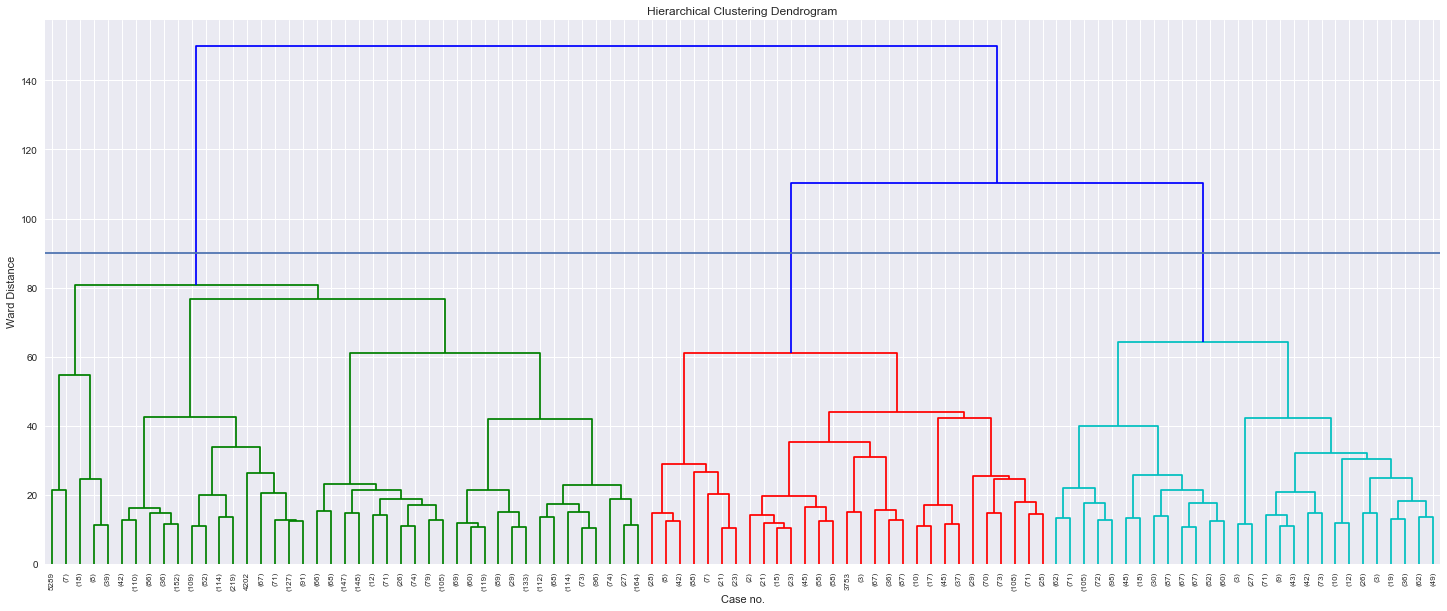

In [358]:
# Hierarchical clustering to explore natural number of clusters 
Z = linkage(subset[new_vars], 'ward')
# Full Dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Case no.')
plt.ylabel(' Ward Distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.axhline(y=90, xmin=0, xmax=1, hold=None)
plt.show()

Firstly, hierarchical clustering is performed in advance to determine initial number of k (clusters) in K-means clustering algorithm. A sensibile cut-off based on the Dendogram is probably around 90 in Ward Distance, which gave out a result of 3 clusters in total.

In [327]:
# Define K-means clustering
def k_means_alg(k):
    clf = KMeans(init='k-means++', n_clusters=k)
    k_features = new_vars
    clf.fit(subset[k_features])
    labels = clf.predict(subset[k_features])
    subset['Cluster'] = labels
    
    fig = plt.figure(figsize=(12,12))
    for i in range(k):
        plt.scatter(subset['X'][subset.Cluster==i], subset['Y'][subset.Cluster==i], 
                    c=my_colors[i], label='Cluster '+str(i))

    plt.legend()
    plt.xlabel('Lattitude')
    plt.ylabel('Longtitude')
    plt.title('k-Means with ' + str(k) + ' clusters')
    plt.legend(loc='lower left', ncol=2, fontsize=12)
    plt.show()
    
    # Summary table in original scale
    centroids = pd.DataFrame(clf.cluster_centers_)
    centroids.columns = old_vars
    for col in centroids.columns:
        centroids[col] = (centroids[col] * subset[col].std()) + subset[col].mean()
    print(centroids)
        

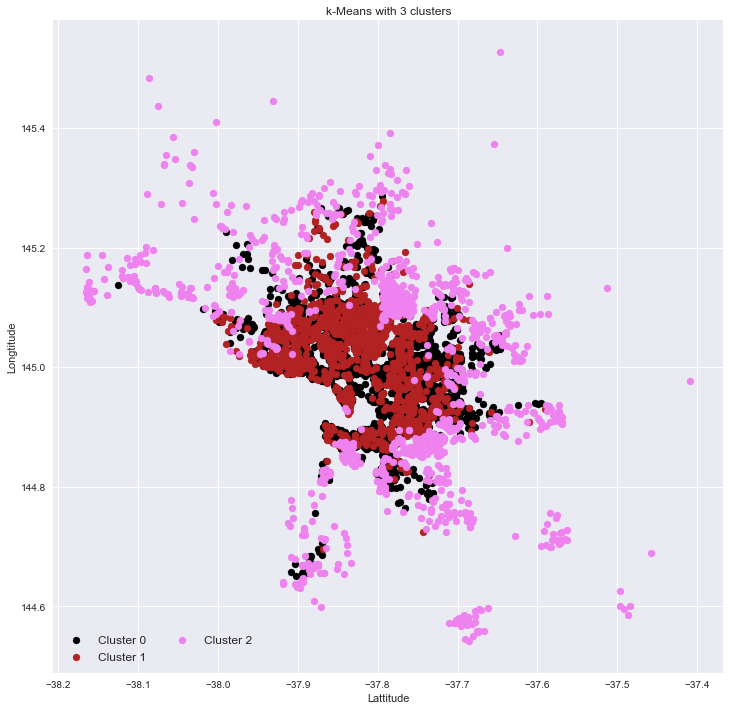

       Price  Rooms  Bedroom2  Bathroom  Landsize  BuildingArea   Age  \
0  961158.14   2.63      2.60      1.28    529.30        114.05 60.95   
1 1911861.68   4.14      4.09      2.38    606.33        240.18 61.66   
2  817448.82   3.50      3.49      1.85    623.84        166.32 31.50   

   Distance_CBD  Distance_train  Distance_hospital  Distance_school  
0          8.81         1048.90            1759.61           464.54  
1          9.41         1182.15            1624.30           474.64  
2         17.92         2610.75            3710.38           679.84  


In [328]:
# Implement K-means with 3 clusters
k_means_alg(3)

Based on the cluster centroids and several graphs categorized by cluster below, we can divide the houses into 3 main groups: <br>
Group 0 (black cluster): Medium in price (800,000 to just above 1,000,000 range), small in building area, small in landsize, less bathroom, less bedroom, medium in age, close to CBD and close to other public services (train, hospital, school).<br>
Group 1 (red cluster): High in price (above 1,500,000, big in building area, medium in landsize, many bathrooms, many bedrooms, medium in age, close to CBD and close to other public services.<br>
Group 2 (pink cluster): Low in price (400,000 to just below 1,000,000), big in building area, big in landsize, average number of bathrooms, average number of bedrooms, new in age, far from CBD and far to other public services.<br>


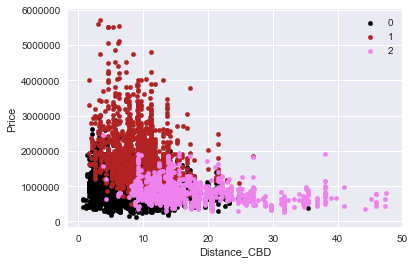

In [333]:
# Clustering with Price and Distance to CBD 
fig, ax = plt.subplots()
grouped = subset.groupby('Cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Distance_CBD', y='Price', label=key, color=my_colors[key])
plt.show()

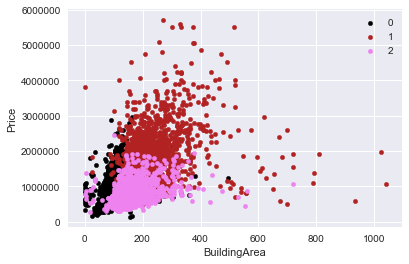

In [330]:
# Clustering with Price and Building Area
fig, ax = plt.subplots()
grouped = subset.groupby('Cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='BuildingArea', y='Price', label=key, color=my_colors[key])
plt.show()

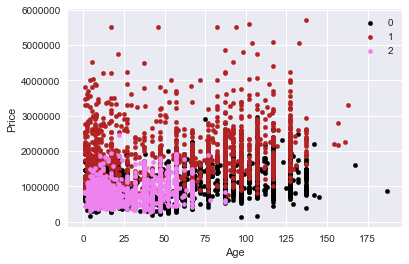

In [332]:
# Clustering with Price and Age
fig, ax = plt.subplots()
grouped = subset.groupby('Cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Age', y='Price', label=key, color=my_colors[key])
plt.show()

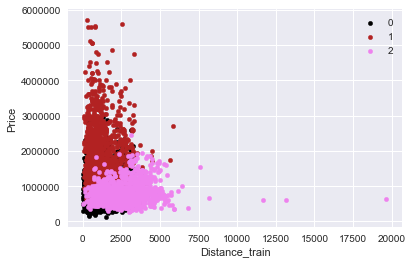

In [340]:
# Clustering with Distance to train and Price
fig, ax = plt.subplots()
grouped = subset.groupby('Cluster')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Distance_train', y='Price', label=key, color=my_colors[key])
plt.show()

##### Conclusion
This report implements several prediction techniques such as Linear Regression, Hierarchical and K-means clustering together with several exploratory analysis to provide a basic understanding of Melbourne's House Market. Although the predictive power of the models need to be tested on upcoming real datasets, the models also have their own practical values. While Linear Regression provides a price prediction taken into account different features of a house in general, K-means clustering enables investors to classify a specific house into one in three clusters based on its characteristics to estimate the real value of it. It then enables investors to make better decision in property investment, or allows sellers to adjust their prices appropriately according to the market.

##### Recommendations for future development 
This project should be expanded with regards to: <br>
Add new distance variables such as Distance to the closest worship place, bus stop, restaurants, etc. <br>
Better approach for dealing with missing values to keep the number of records as many as possible. <br>
Combine the dataset with other demographic and social factors such as suburb's income, crime rates, etc. and further explore how such features affect the house's prices of a specific suburb. <br>
More concerns and better approachs to discover the market effects on prices (non-characteristics factors). <br>


##### References
https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>
https://stackoverflow.com/questions/<br>
https://pypi.python.org/pypi/geopy<br>
https://data.melbourne.vic.gov.au/<br>
https://www.ptv.vic.gov.au/<br>
https://aurin.org.au/<br>
https://en.wikipedia.org/wiki/List_of_Melbourne_railway_stations<br>

